In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
df2014 = pd.read_csv('../../dataset/data2014.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)
df2015 = pd.read_csv('../../dataset/data2015.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)
df2016 = pd.read_csv('../../dataset/data2016.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)
df2017 = pd.read_csv('../../dataset/data2017.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)
df2018 = pd.read_csv('../../dataset/data2018.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)
df2019 = pd.read_csv('../../dataset/data2019.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)
df2020 = pd.read_csv('../../dataset/data2020.csv', index_col = 'datahora', usecols = ['datahora', 'riscofogo', 'precipitacao'], parse_dates = True)

In [5]:
df_all = pd.concat([df2014, df2015, df2016, df2017, df2018, df2019, df2020]).sort_index()

df_all = df_all[df_all.riscofogo == 1]

df_fire = df_all[['riscofogo']].resample('SM').sum()
df_prec = df_all[['precipitacao']].resample('SM').mean()

df_fire.to_csv('fire.csv')
df_prec.to_csv('prec.csv')

In [13]:
class AnomalyDetection:
    def __init__(self, timeseries, period):
        self.timeseries = timeseries
        self.period = period
    
    def stl_decomp(self):
        stl = STL(self.timeseries, self.period)
        decomposed_result = stl.fit()
        seasonal, trend, residuals = decomposed_result.seasonal, decomposed_result.trend, decomposed_result.resid
        return seasonal, trend, residuals
    
    def decomposition(self):
        
        seasonal, trend, residuals = AnomalyDetection.stl_decomp(self)

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 10))
        
        ax1.plot(self.timeseries, c = 'grey')
        ax1.set_title('Timeseries')
        ax2.plot(seasonal, c = 'grey')
        ax2.set_title('Seasonality')
        ax3.plot(trend, c = 'grey')
        ax3.set_title('Trend')
        ax4.plot(residuals, c = 'grey')
        ax4.set_title('Residuals')
        
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.show()
        
    def seasonal_trend(self):
        seasonal, trend, residuals = AnomalyDetection.stl_decomp(self)
        
        fig, ax = plt.subplots(figsize = (12, 8))
        ax.plot(self.timeseries, label = 'Timeseries', c = 'grey', linestyle = '--')
        ax.plot(seasonal + trend, label = "Trend + seasonality", c = 'k', alpha = 0.8)
        ax.set_title('Difference due to the \ntimeseries residuals', fontsize = 18)
        ax.plot(residuals, label = 'Residuals', color = 'tomato', alpha = 0.4)
        ax.set_xlim(df_all.index[0], df_all.index[-1])
        
        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.show()
        return fig
    
    def residuals_analysis(self, n_sigma = 3):
        residuals = AnomalyDetection.stl_decomp(self)[2]
        residuals_mean = residuals.mean()
        residuals_std = residuals.std()

        ## Getting the lower and upper values of it
        lower = residuals_mean - n_sigma*residuals_std
        upper = residuals_mean + n_sigma*residuals_std

        fig, ax = plt.subplots(figsize = (12, 8))
        ax.plot(residuals, color = 'k', linewidth = 1)

        ax.fill_between([self.timeseries.index[0], self.timeseries.index[-1]], lower, upper,
                        label = '{} $\sigma$ range'.format(n_sigma),
                        color = 'salmon', alpha = 0.2,
                        linestyle = '--', linewidth = 2)

        ax.set_xlim(self.timeseries.index[0], self.timeseries.index[-1])
        ax.set_title('Residuals', fontsize = 20)

        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def anomaly_points_timeseries(self, n_sigma = 3):
        seasonal, trend, residuals = AnomalyDetection.stl_decomp(self)
        residuals_mean = residuals.mean()
        residuals_std = residuals.std()

        ## Getting the lower and upper values of it
        lower = residuals_mean - n_sigma*residuals_std
        upper = residuals_mean + n_sigma*residuals_std
        
        anomaly_dates = self.timeseries[(residuals > upper) | (residuals < lower)]
        
        fig, ax = plt.subplots(figsize = (12,8))
        ax.plot(self.timeseries, label = 'Timeseries', c = 'grey', linestyle = '--')
        ax.plot(seasonal+trend, label = "Trend + seasonal", c = 'k', alpha = 0.8)
        
        ax.scatter(anomaly_dates.index, anomaly_dates, color = 'r', marker = 'D', label = 'Anomaly events')

        ax.set_title('Timeseries and anomaly detection', fontsize = 16)
        ax.set_xlim(self.timeseries.index[0], self.timeseries.index[-1])

        plt.gcf().autofmt_xdate()
        plt.legend()
        plt.show()

    def corrected_timeseries(self, n_sigma = 3):
        residuals = AnomalyDetection.stl_decomp(self)[2]
        residuals_mean = residuals.mean()
        residuals_std = residuals.std()
        
        lower = residuals_mean - n_sigma*residuals_std
        upper = residuals_mean + n_sigma*residuals_std
        
        # getting the part of the dataframe which contains the anomalies 
        anomaly_dates = self.timeseries[(residuals > upper) | (residuals < lower)]
        
        timeseries_ac = self.timeseries.copy()
        
        for date in anomaly_dates.index:
            condition = (timeseries_ac.index.day == date.day) & (timeseries_ac.index.month == date.month) & (timeseries_ac.index.year != date.year)
            corrected_value = timeseries_ac[condition].mean() # take the mean for of previous years
            timeseries_ac.loc[date].iat[0] = corrected_value  # change the anomaly event
        return timeseries_ac
    
    def corrected_timeseries_plot(self, n_sigma = 3):
        timeseries_ac = AnomalyDetection.corrected_timeseries(self, n_sigma)
        
        fig, ax = plt.subplots(figsize = (12,8))

        ax.plot(self.timeseries, linestyle = '--', color = 'grey', label = 'ordinary')
        ax.plot(timeseries_ac, color = 'red', label = 'corrected', alpha = 0.6)

        ax.set_xlabel('Years', fontsize = 14)
        ax.set_ylabel('Number of events', fontsize = 14)
        ax.set_title('Corrected and ordinary \ndatasets', fontsize = 18)

        plt.gcf().autofmt_xdate()
        plt.legend(fontsize = 12)

        plt.show()

In [49]:
preciptation = AnomalyDetection(df_prec, 52)
#preciptation.decomposition()
#preciptation.seasonal_trend()
#preciptation.residuals_analysis()
#preciptation.anomaly_points_timeseries(3)
preciptation.corrected_timeseries(3)
#preciptation.corrected_timeseries_plot(2.5)

,precipitacao
datahora,
2013-12-31,0.752338
2014-01-15,0.357155
2014-01-31,0.563837
2014-02-15,0.494017
2014-02-28,0.750000
...,...
2020-09-15,0.116392
2020-09-30,0.114638
2020-10-15,0.162510


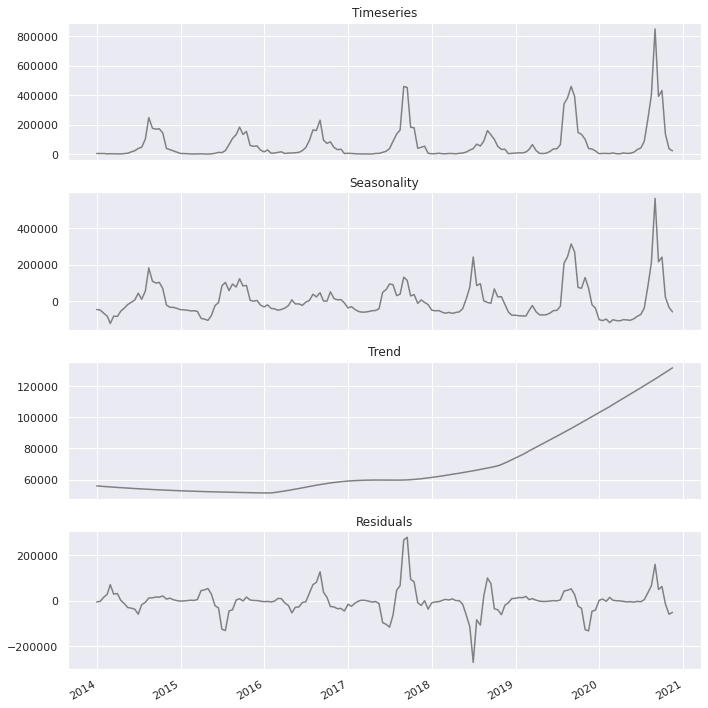

In [16]:
fire = AnomalyDetection(df_fire, 52)
fire.decomposition()
#preciptation.seasonal_trend()
#preciptation.residuals_analysis()
#fire.anomaly_points_timeseries(3)
#preciptation.corrected_timeseries(3)
#preciptation.corrected_timeseries_plot(2.5)